In [1]:
# !cp drive/MyDrive/python檔/aicup/run/dataset.py .
# !cp drive/MyDrive/python檔/aicup/run 

# loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.insert(0,"/content/drive/My Drive/python檔/aicup/run")

In [4]:
pip install transformers==3

In [5]:
pip install pytorch-crf

In [6]:
pip install pytorch_warmup

In [7]:
# from dataset import bert_stc_dataset
# from model2 import model_crf
from train import train
# from txt_preprocess2 import preprocess2
import re
import time
import csv

from transformers import BertModel, BertTokenizer, get_cosine_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchcrf import CRF
import pytorch_warmup as warmup
# from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [8]:
file_path = '/content/drive/My Drive/python檔/aicup/run/data/train2_input.data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('{} is being used'.format(device))

cuda is being used


# dataset

In [9]:
from torch.utils.data import Dataset
import torch

class bert_stc_dataset(Dataset):
    
    def __init__(self, stcs, labels, tokenizer, max_length):
        
        self.stcs = stcs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_labels = []

        # 已經在preprocess2 做完label 0 padding
        for i in range(len(labels)):
            temp_label = [0]*max_length
            temp_label[:len(labels[i])] = labels[i]
            self.pad_labels.append(temp_label)
            
        
    def __len__(self):
        return len(self.stcs)
    
    def __getitem__(self, idx):
        
        txt = str(self.stcs[idx])
        
        txt = ' '.join(list(txt)) #中間要有空格，數字才會分類準確
        # print(txt)
        
        encoding = self.tokenizer.encode_plus(
            txt,
#             truncation= True,
            max_length= self.max_length,
            padding = 'max_length',
            add_special_tokens=False,
#             pad_to_multiple_of=True,
            return_attention_mask= True,
            return_token_type_ids= False,
            return_tensors='pt')
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels' : torch.tensor(self.pad_labels[idx], dtype= torch.long)
        }

# preprocess

In [10]:
class preprocess2():
  def __init__(self, data):
    self.data = data
    self.data_list= list()
    data_list_tmp = list()

    for row in data:
      data_tuple = tuple()
      if row == '\n':
        if (len(data_list_tmp) != 0):
          self.data_list.append(data_list_tmp)
          data_list_tmp = []

      else:
        row = row.strip('\n').split(' ')

        if (row[0] in ['。', '？','！','～','，', '：']) & (len(data_list_tmp) >= 128):
          self.data_list.append(data_list_tmp)
          data_list_tmp= []
        
        elif row[0] in ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']:
          data_tuple = (row[0].lower(), row[1])
        #   print(row[0].lower())
          data_list_tmp.append(data_tuple)

        else: #row[0] not in ['欸','喔','诶','摁','嗯','齁','嗎','嘿','哦','？','！','。', '～', '：'] :
          data_tuple = (row[0], row[1])
          data_list_tmp.append(data_tuple)

        #data_list_tmp 儲存暫時的data_tuple(token,label)
    if len(data_list_tmp) != 0:
      self.data_list.append(data_list_tmp)

    # print(self.data_list[0])

  def get_stc_label(self):

    all_stcs = list()
    all_labels = list()

    for stc_tuples in self.data_list:

      txt_len = len(stc_tuples) #(文章數，每個文章對應的總字數) (word, label)
      stcs = str() #存字數= max_stc_len的字串
      labels = []


      for idx, (word, label) in enumerate(stc_tuples):

        stcs += word
        labels.append(label)

    #   stcs = re.sub(r'(醫師：)|(個管師：)|(民眾：)|(家屬：)|(護理師：)', '', stcs)
        
    #   stc_split_list  = re.split(r'。|？|！|～', stcs)

    #   clean_stc_list = [ stc for stc in stc_split_list if stc not in ['摁','嗯','啦','喔','欸','啊','齁','嘿','嘛','對','了解','對阿','是']]
    #   # print(clean_stc_list)
    #   stc = '。'.join(clean_stc_list)

      if len(set(labels)) > 0: # downsamping

        all_stcs.append(stcs)
        all_labels.append(labels)

    return all_stcs, all_labels


  def tag2id(self, stcs_label):

    all_label = list()
    for stc_label in stcs_label:
      for label in stc_label:
        all_label.append(label)

    labels_set = sorted(set(all_label))
    tag2id_dict = {}

    for idx, label in enumerate(labels_set):
      tag2id_dict[label] = idx

    return tag2id_dict

  def label_to_ids(self, tag_to_id, raw_labels):

    label2id = []
    for stc_labels in raw_labels:
      stc_label_ids = [tag_to_id[label] for label in stc_labels]
      label2id.append(stc_label_ids)
    return label2id

  def get_stcs_label2ids(self):

    stcs, labels = self.get_stc_label()
    tag2id = self.tag2id(stcs_label= labels)
    labels_ids= self.label_to_ids(tag_to_id= tag2id, raw_labels= labels)

    return stcs, labels, labels_ids

# model

In [11]:
class model_crf(nn.Module):
	def __init__(self, n_tags, hidden_dim=768, batchsize= 32, num_layers= 1, lstm_dropout= 0, fc_dropout= 0.2):
		super(model_crf, self).__init__()
		self.num_layers = num_layers
		self.n_tags = n_tags
		self.lstm =  nn.LSTM(bidirectional=True, num_layers=num_layers, input_size=768, hidden_size=hidden_dim//2, dropout= lstm_dropout, batch_first=True)		
		self.hidden_dim = hidden_dim
		self.fc = nn.Linear(hidden_dim, self.n_tags)
		self.bert = BertModel.from_pretrained('bert-base-chinese')

		# for param in self.bert.parameters():
		# 	param.requires_grad = False
		# self.bert.eval()  # 知用来取bert embedding

		self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
		self.CRF = CRF(n_tags, batch_first= True)
		self.dropout = nn.Dropout(p= fc_dropout)
		self.hidden = self.init_hidden(batchsize)

	def init_hidden(self, batch_size):
		return (torch.randn(2*self.num_layers, batch_size, self.hidden_dim // 2).to(self.device),
				torch.randn(2*self.num_layers, batch_size, self.hidden_dim // 2).to(self.device))

	def forward(self, input_ids, attention_mask, tags):

		batch_size = input_ids.size(0)
		max_seq_len = input_ids.size(1)
		bert_output, _  = self.bert(input_ids.long(), attention_mask)
		seq_len = torch.sum(attention_mask, dim= 1).cpu().int()
		# print(seq_len)
		pack_input = pack_padded_sequence(input= bert_output, lengths= seq_len, batch_first= True, enforce_sorted= False)
		packed_lstm_out, _ = self.lstm(pack_input,self.init_hidden(batch_size= batch_size))
		lstm_enc, _=  pad_packed_sequence(packed_lstm_out, batch_first=True)
		# print(lstm_enc.size())
		lstm_enc = self.dropout(lstm_enc)
		lstm_feats = self.fc(lstm_enc)

		lstm_max_seq_len = lstm_feats.size(1)
		pad = torch.zeros(size=(batch_size, max_seq_len-lstm_max_seq_len, self.n_tags), dtype= torch.float).to(self.device)
		lstm_feats= torch.cat((lstm_feats, pad), dim= 1)

		# focal loss 權重調整
		lstm_feats[:,:,:-2] = lstm_feats[:,:,:-2]*100
		lstm_feats[:,:,-2] = lstm_feats[:,:,-2]*100

		loss = -self.CRF(lstm_feats, tags, attention_mask.bool(), reduction= 'mean')
		pred_seqs = self.CRF.decode(emissions= lstm_feats, mask= attention_mask.bool())
  
		return loss, pred_seqs

# 載入stcs, tags

{'B-ID': 0, 'B-clinical_event': 1, 'B-contact': 2, 'B-education': 3, 'B-family': 4, 'B-location': 5, 'B-med_exam': 6, 'B-money': 7, 'B-name': 8, 'B-organization': 9, 'B-others': 10, 'B-profession': 11, 'B-time': 12, 'I-ID': 13, 'I-clinical_event': 14, 'I-contact': 15, 'I-education': 16, 'I-family': 17, 'I-location': 18, 'I-med_exam': 19, 'I-money': 20, 'I-name': 21, 'I-organization': 22, 'I-others': 23, 'I-profession': 24, 'I-time': 25, 'O': 26}
tags數: 27
0|0.000051
1|0.000012
2|0.000125
3|0.000014
4|0.000120
5|0.000667
6|0.001067
7|0.000303
8|0.000672
9|0.000002
10|0.000007
11|0.000101
12|0.006081
13|0.000154
14|0.000036
15|0.000520
16|0.000029
17|0.000132
18|0.001016
19|0.002054
20|0.000754
21|0.001216
22|0.000005
23|0.000014
24|0.000210
25|0.013227
26|0.971407


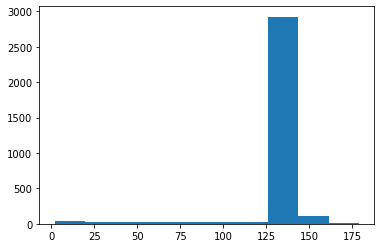

max_length 179


In [12]:
# ---------------前處理---------------
with open(file_path, 'r', encoding='utf-8') as f:
	data=f.readlines()#.encode('utf-8').decode('utf-8-sig')

preprocessor = preprocess2(data)

stcs, original_labels, labels = preprocessor.get_stcs_label2ids()
tag2id_dict = preprocessor.tag2id(original_labels)
id2tag_dict = {v:k for k,v in tag2id_dict.items()}

n_tags = len(tag2id_dict)
print(tag2id_dict)
print('tags數: {}'.format(n_tags))

gt_tags = [tag for label in labels for tag in label]

for tag in set(gt_tags):
  print('{}|{:.6f}'.format(tag, gt_tags.count(tag)/len(gt_tags)))
# plt.hist(gt_tags)
plt.hist([len(stc) for stc in stcs])
plt.show()


tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
max_length = len(max(stcs, key=len)) 
print('max_length', max_length)

# 參數設定

In [13]:
# --------------- 現在model只有單層 ---------------
batchsize= 32
hidden_dim= 256
num_epochs= 20
lr = 1e-4
weight_decay = 1e-2
warmup_ratio = 0.3
lstm_dropout = 0 # No dropout better?
fc_dropout = 0.5
num_layers = 2

model = model_crf(n_tags= n_tags, hidden_dim= hidden_dim, batchsize= batchsize, num_layers= num_layers, lstm_dropout= lstm_dropout, fc_dropout= fc_dropout).to(device)
# print(summary(model,[(128, 300), (128,300)]))

train_x, test_x, train_y, test_y = train_test_split(stcs, labels, test_size= 0.2, shuffle= True, random_state= 42)
print('training size: {}'.format(len(train_x)))
print('test size: {}'.format(len(test_x)))
print('test gt tags unique數 :{}'.format(len(set([tag for label in test_y for tag in label]))))

train_dataset = bert_stc_dataset(stcs= train_x, labels= train_y, tokenizer= tokenizer, max_length= max_length)
# print('train stcs ',train_x[0:3])
# print(train_dataset[0:3]['input_ids'])
# print(train_dataset[0:3]['labels'])
test_dataset = bert_stc_dataset(stcs= test_x, labels= test_y, tokenizer= tokenizer, max_length= max_length)

# print('training stcs 總數: {}'.format(len(train_dataset)))
train_dataloader = DataLoader(train_dataset, batch_size= batchsize, shuffle= True, num_workers= 4)
test_dataloader = DataLoader(test_dataset, batch_size= batchsize, shuffle= False, num_workers= 4)

num_iteration = len(train_dataloader)
print('num_iteration',num_iteration)
total_iter = num_iteration * num_epochs
warmup = total_iter * warmup_ratio
optimizer = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay= weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps= warmup, num_training_steps=total_iter)
# warmup_scheduler = warmup.ExponentialWarmup(optimizer, warmup_period=150)

# ---------------訓練---------------
# train_model = train(model= model, optimizer= optimizer, train_loader= train_dataloader, test_loader= 0, num_epochs= 5, device= device)

training size: 2590
test size: 648
test gt tags unique數 :19
num_iteration 81


# test function

In [14]:
def test(model, test_dataloader, device):

  preds_epoch = []
  gts_epoch = []
  epoch_loss = 0
  iteration = 0

  model.eval()

  for idx, batch_dict in enumerate(test_dataloader):

    # print('idx: ',idx+1)
    input_ids = batch_dict['input_ids'].to(device)
    attention_mask = batch_dict['attention_mask'].to(device)
    labels = batch_dict['labels'].to(device)

    with torch.no_grad():
      loss, pred_labels = model(input_ids, attention_mask.bool(), labels)

    # mask gt labels 
    labels = batch_dict['labels'].numpy()
    masks = batch_dict['attention_mask'].numpy()

    labels_nopad = []
    for label , seq_mask in zip(labels, masks):

      seq = [tag for tag, mask in zip(label, seq_mask) if mask == 1]
      labels_nopad.append(seq)

    # one dim array 
    preds= [tag for seq in pred_labels for tag in seq]
    gts= [tag for seq in labels_nopad for tag in seq]

    preds_epoch += preds
    gts_epoch += gts

    epoch_loss += loss.item()
    iteration += 1

  target_names = sorted([id for id in set(gts_epoch).union(set(preds_epoch))], reverse= False)
  target_names = [id2tag_dict[id] for id in target_names]
  f1_macro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'macro')
  f1_micro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'micro')
  f1 = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= None)
  print(classification_report(y_true= gts_epoch, y_pred= preds_epoch, target_names= target_names))
  
  avg_loss = epoch_loss / iteration

  print('gt tag unique 數: {}'.format(len(set(gts_epoch))))
  print('pred tag unique 數: {}'.format(len(set(preds_epoch))))
  print('test_f1(macro, micro) ({:.2f},{:.2f}) | test_avg_loss {:.3f} | f1 for each class\n{}\n'.format(f1_macro, f1_micro, avg_loss, f1))

  return f1_macro, f1_micro, avg_loss

# test out function

In [15]:
class test_output():
	def __init__(self, data, model, tokenizer, batch_size):

		self.model = model
		self.model.eval()
		self.tokenizer = tokenizer
		self.batch_size = batch_size
		self.data_list = []
		self.word_id = []
		self.word_article_id = [] 
		article_id = 0
		word_id = 0
		data_list_tmp = []
		article_id_tmp = []
		word_id_tmp = []
		
		for row in data:
			
			data_tuple = tuple()
			if row == '\n':
				
				article_id += 1 
				word_id = 0

				if len(data_list_tmp) != 0:

					self.word_id.append(word_id_tmp)
					self.word_article_id.append(article_id_tmp)
					self.data_list.append(data_list_tmp)
				data_list_tmp = []
				article_id_tmp = []
				word_id_tmp = []

			else:
				
				row = row.strip('\n').split(' ')

				# if (row[0] in ['，', '：']) & (len(data_list_tmp) > 136):
				# 	self.word_id.append(word_id_tmp)
				# 	self.word_article_id.append(article_id_tmp)
				# 	self.data_list.append(data_list_tmp)
				# 	data_list_tmp = []
				# 	article_id_tmp = []
				# 	word_id_tmp = []
				
				if (row[0] in ['。', '？','！','～','‧','，', '：']) & (len(data_list_tmp) > 128):
					
					self.word_id.append(word_id_tmp)
					self.word_article_id.append(article_id_tmp)
					self.data_list.append(data_list_tmp)
					data_list_tmp = []
					article_id_tmp = []
					word_id_tmp = []
					
				elif row[0] in ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']:
					  
					data_tuple = (row[0].lower(), article_id, word_id)
					data_list_tmp.append(data_tuple)
					article_id_tmp.append(article_id)
					word_id_tmp.append(word_id)

				else: #row[0] not in ['欸','喔','诶','摁','嗯','齁','嗎','嘿','哦','？','！','。', '～', '：']:
					
					data_tuple = (row[0], article_id, word_id)
					data_list_tmp.append(data_tuple)
					article_id_tmp.append(article_id)
					word_id_tmp.append(word_id)
					
				word_id += 1
				
		if len(data_list_tmp) != 0:
			self.data_list.append(data_list_tmp)
			self.word_id.append(word_id_tmp)
			self.word_article_id.append(article_id_tmp)
		max_len = len(max(self.data_list, key= len))
		print('max_len: ', max_len)
  
	def raw_output(self):
		return self.data_list, self.word_id, self.word_article_id

	def get_stcs(self):
		
		all_stcs = list()
		all_article_ids = list()
		all_word_ids = list()

		for idx, stc_list in enumerate(self.data_list):

			txt_len = len(stc_list) #(文章數，每個文章對應的總字數) (word, label)
			stc = str() #存字數= max_stc_len的字串
			article_ids = []
			word_ids = []
			

			for i, (word,article_id, word_id) in enumerate(stc_list):

				stc += word
				article_ids.append(article_id)
				word_ids.append(word_id)

			if len(stc) > 0:
				all_stcs.append(stc)
				all_article_ids.append(article_ids)
				all_word_ids.append(word_ids)

			else: 
				print(stc)
				print(idx)
				print(article_ids)
				print(word_ids)
				print('stc len = 0')
		assert len(all_stcs) > 0, 'all stcs len = 0' 
		
		return all_stcs, all_article_ids, all_word_ids

	def encoding(self):
    
		clean_stcs, _, _ = self.get_stcs()
		max_len = len(max(clean_stcs, key= len))

		clean_stcs = [' '.join(list(stc)) for stc in clean_stcs]

        encoding = self.tokenizer.batch_encode_plus(clean_stcs, 
			padding=True,
			add_special_tokens=False,
			return_attention_mask= True,
			return_token_type_ids= False,
			#  is_split_into_words=True,
			return_tensors='pt')

		# batch_size= 32
		pred_labels = []
        
		self.model.eval()
		for idx in range(int((len(clean_stcs)/self.batch_size))):
			input= encoding['input_ids'][idx*self.batch_size:(idx+1)*self.batch_size].to(device)
			mask = encoding['attention_mask'][idx*self.batch_size:(idx+1)*self.batch_size].to(device)
			tags= torch.zeros((input.size(0),input.size(1)), dtype=torch.long).to(device)
			with torch.no_grad():
				_, preds = self.model(input, mask, tags)
			for pred in preds:
				pred_labels.append(pred)

		if (len(clean_stcs) % self.batch_size) != 0:
			idx = int((len(clean_stcs)/self.batch_size))
			input= encoding['input_ids'][idx*self.batch_size:].to(device)
			mask = encoding['attention_mask'][idx*self.batch_size:].to(device)
			tags= torch.zeros((input.size(0),input.size(1)), dtype=torch.long).to(device)
			with torch.no_grad():
				_, preds = self.model(input, mask, tags)
			for pred in preds:
				pred_labels.append(pred)

		tag2id = {'B-ID': 0, 'B-clinical_event': 1, 'B-contact': 2, 'B-education': 3, 'B-family': 4, 'B-location': 5, 'B-med_exam': 6, 'B-money': 7, 'B-name': 8, 'B-organization': 9, 'B-others': 10, 'B-profession': 11, 'B-time': 12, 'I-ID': 13, 'I-clinical_event': 14, 'I-contact': 15, 'I-education': 16, 'I-family': 17, 'I-location': 18, 'I-med_exam': 19, 'I-money': 20, 'I-name': 21, 'I-organization': 22, 'I-others': 23, 'I-profession': 24, 'I-time': 25, 'O': 26}
		id2tag ={v:k for k, v in tag2id.items()}

		self.pred_labels_tag = []
		for stc, label in zip(clean_stcs, pred_labels):
			# print(stc)
			# print(label)
			stc_label = [id2tag[id] for id in label]
			self.pred_labels_tag.append(stc_label)

		return self.pred_labels_tag

	def pred_out_tsv(self, pred_labels_tag):
		
		clean_stcs, clean_article_id, clean_word_id = self.get_stcs()
		# pred_labels_tag = self.encoding()

		entity_text = []

		for stc, labels, article_id, word_id in zip(clean_stcs, pred_labels_tag, clean_article_id, clean_word_id):

			entity = str()
			start_pos = 0
			end_pos = 0
			article = 0
			entity_type = str()
			pointer = 0

			for idx, label in enumerate(labels):

				if bool(re.match(r'B-', label)):

					entity = list(stc)[idx]
					start_pos = word_id[idx]
					article = article_id[idx]
					entity_type = label.split('B-')[1]
					pointer = idx

				elif bool(re.match(r'I-', label)):
					if (idx - pointer) == 1:
						entity += list(stc)[idx]
						end_pos= word_id[idx]+1
						try:
							if ((labels[idx+1] == 'O')|(bool(re.match(r'B-', labels[idx+1])))) & (entity_type!=''):
								entity_text.append((article, start_pos, end_pos, entity, entity_type))
								entity = str()
								start_pos = 0
								end_pos = 0
								article = 0
								entity_type = str()
							elif bool(re.match(r'I-', labels[idx+1])):
								pointer= idx
						except:
							pass

		with open('test_output.tsv', 'w', encoding='utf-8',newline='\n') as f:
			writer = csv.writer(f, delimiter='\t')
			writer.writerow(['article_id','start_position', 'end_position', 'entity_text', 'entity_type'])
			for (article, start_pos, end_pos, entity, entity_type) in entity_text:
				writer.writerow([str(article), str(start_pos), str(end_pos), str(entity), str(entity_type)])

		return entity_text


# 訓練

In [ ]:
train_loss = {}
test_loss = {}
train_f1 = {}
test_f1 = {}
stop_epoch = 0

for epoch in range(num_epochs):

  preds_epoch = []
  gts_epoch = []
  epoch_loss = 0
  iteration = 0
  st = time.time()

  model.train()

  for idx, batch_dict in enumerate(train_dataloader):

    # print('idx: ',idx+1)
    input_ids = batch_dict['input_ids'].to(device)
    attention_mask = batch_dict['attention_mask'].to(device)
    labels = batch_dict['labels'].to(device)

    loss, pred_labels = model(input_ids, attention_mask.bool(), labels)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

    optimizer.step()
    scheduler.step()
    model.zero_grad()

    # mask gt labels 
    labels = batch_dict['labels'].numpy()
    masks = batch_dict['attention_mask'].numpy()

    labels_nopad = []
    for label , seq_mask in zip(labels, masks):

        seq = [tag for tag, mask in zip(label, seq_mask) if mask == 1]
        labels_nopad.append(seq)

    # one dim array 
    preds= [tag for seq in pred_labels for tag in seq]
    gts= [tag for seq in labels_nopad for tag in seq]

    preds_epoch += preds
    gts_epoch += gts

    epoch_loss += loss.item()
    iteration += 1

  target_names = sorted([id for id in set(gts_epoch).union(set(preds_epoch))], reverse= False)
  target_names = [id2tag_dict[id] for id in target_names]
  f1_macro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'macro')
  f1_micro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'micro')
  f1 = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= None)
  print(classification_report(y_true= gts_epoch, y_pred= preds_epoch, target_names= target_names))
  
  avg_loss = epoch_loss / iteration
  stop_epoch = epoch+1
  en = time.time()
  
  print('training time :{:.2f}'.format(en-st))
  print('epoch {}/{} | train_f1(macro, micro) ({:.2f},{:.2f}) | train_epoch_avg_loss {:.3f}| f1 for each class \n{}\n'.format(epoch+1, num_epochs, f1_macro, f1_micro, avg_loss, f1))

  test_f1_macro, test_f1_micro, test_avg_loss = test(model= model, test_dataloader= test_dataloader, device= device)

  train_loss[epoch+1] = avg_loss
  test_loss[epoch+1] = test_avg_loss
  train_f1[epoch+1] = f1_macro
  test_f1[epoch+1] = test_f1_macro


                  precision    recall  f1-score   support

            B-ID       0.00      0.05      0.00        21
B-clinical_event       0.00      0.00      0.00         5
       B-contact       0.00      0.02      0.00        47
     B-education       0.00      0.00      0.00         5
        B-family       0.00      0.03      0.00        32
      B-location       0.00      0.01      0.00       223
      B-med_exam       0.00      0.01      0.00       329
         B-money       0.00      0.01      0.00        95
          B-name       0.00      0.03      0.00       207
  B-organization       0.00      0.00      0.00         1
        B-others       0.00      0.00      0.00         3
    B-profession       0.00      0.03      0.00        33
          B-time       0.00      0.02      0.01      2031
            I-ID       0.00      0.11      0.00        64
I-clinical_event       0.00      0.07      0.00        15
       I-contact       0.00      0.03      0.00       198
     I-educat

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

            B-ID       0.00      0.00      0.00        21
B-clinical_event       0.00      0.00      0.00         5
       B-contact       0.00      0.00      0.00        47
     B-education       0.00      0.00      0.00         5
        B-family       0.00      0.00      0.00        32
      B-location       0.00      0.01      0.01       223
      B-med_exam       0.01      0.04      0.02       329
         B-money       0.00      0.00      0.00        95
          B-name       0.00      0.00      0.00       207
  B-organization       0.00      0.00      0.00         1
        B-others       0.00      0.00      0.00         3
    B-profession       0.00      0.00      0.00        33
          B-time       0.14      0.14      0.14      2031
            I-ID       0.00      0.02      0.00        64
I-clinical_event       0.00      0.00      0.00        15
       I-contact       0.00      0.01      0.00       198
     I-educat

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

            B-ID       0.00      0.00      0.00        21
B-clinical_event       0.00      0.00      0.00         5
       B-contact       0.00      0.00      0.00        47
     B-education       0.00      0.00      0.00         5
        B-family       0.01      0.03      0.02        32
      B-location       0.56      0.65      0.61       223
      B-med_exam       0.48      0.53      0.50       329
         B-money       0.18      0.21      0.19        95
          B-name       0.50      0.54      0.52       207
  B-organization       0.00      0.00      0.00         1
        B-others       0.00      0.00      0.00         3
    B-profession       0.00      0.00      0.00        33
          B-time       0.69      0.70      0.69      2031
            I-ID       0.05      0.08      0.06        64
I-clinical_event       0.00      0.00      0.00        15
       I-contact       0.19      0.15      0.17       198
     I-educat

# 訓練成果

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows= 2, ncols= 1, figsize= (10,8), sharex= True)
ax1.plot([*range(1, stop_epoch+1)], list(train_loss.values()), label= 'train loss')
ax1.plot([*range(1, stop_epoch+1)], list(test_loss.values()), label= 'test loss')
ax1.legend()

ax2.plot([*range(1, stop_epoch+1)], list(train_f1.values()), label= 'train f1 (macro)')
ax2.plot([*range(1, stop_epoch+1)], list(test_f1.values()), label= 'test f1 (macro)')
ax2.legend()
plt.savefig('0.74.jpeg')
plt.tight_layout()
plt.show()

In [ ]:
# torch.save(model, '0.74.pt')

In [ ]:
# !cp '0.74.pt' '/content/drive/My Drive/python檔/aicup'

In [ ]:
with open('/content/drive/My Drive/python檔/aicup/test_input.data', 'r', encoding= 'utf-8') as f:
    data = f.readlines()

In [ ]:
test_outputer = test_output(data= data, model= model, tokenizer=tokenizer, batch_size= 16)
data_list, word_ids, article_ids = test_outputer.raw_output()
stcs, article_ids_list, word_ids_list = test_outputer.get_stcs()

print(len(stcs))
print(len(article_ids_list))
print(len(word_ids_list))

idx = 0
for stc, article_id, word_id in zip(stcs, article_ids_list, word_ids_list):
    if idx<100:
        print(stc,'\n', article_id,'\n', word_id, '\n\n')
    idx+=1
# idx = 0
# for stc in data_list:
#     if idx < 100:
#         print(stc, '\n')
#         idx += 1

In [ ]:
pred_labels_tag = test_outputer.encoding()

In [ ]:
for stc, article_ids, word_ids, stc_tags in zip(stcs, article_ids_list, word_ids_list, pred_labels_tag):
    stc_tags_list = []
    if len(set(stc_tags)) > 1:
        for word, article_id, word_id, tag in zip(stc, article_ids, word_ids, stc_tags):
            if tag != 'O':
                stc_tags_list.append((word, article_id, word_id, tag))
        print(stc_tags_list)
        

In [ ]:
preds_ = test_outputer.pred_out_tsv(pred_labels_tag= pred_labels_tag)

In [ ]:
preds_